In [39]:
import time
import os 

In [40]:
#from google.colab import drive
#drive.mount('/content/gdrive')
image_dir = os.getcwd() + '/Images/'
model_dir = os.getcwd() + '/Models/'
output_dir = os.getcwd() + '/Output/'

In [41]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
cuda = torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')
print(device)

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict
import numpy as np

cuda


In [42]:
content_images = ["Content/04.png", "Content/01.png", "Content/05.png", "Content/10.png", "Content/12.png", "Content/19.png"]
style_images = ["Style/01.png", "Style/02.png", "Style/03.png", "Style/10.png", "Style/04.png", "Style/09.png"]
n_iterations = 500

In [43]:
#vgg definition that conveniently let's you grab the outputs from any layer
class VGG(nn.Module):
    def __init__(self, pool='max'):
        super(VGG, self).__init__()
        #vgg modules
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        if pool == 'max':
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        elif pool == 'avg':
            self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool4 = nn.AvgPool2d(kernel_size=2, stride=2)
            self.pool5 = nn.AvgPool2d(kernel_size=2, stride=2)
            
    def forward(self, x, out_keys):
        out = {}
        out['r11'] = F.relu(self.conv1_1(x))
        out['r12'] = F.relu(self.conv1_2(out['r11']))
        out['p1'] = self.pool1(out['r12'])
        out['r21'] = F.relu(self.conv2_1(out['p1']))
        out['r22'] = F.relu(self.conv2_2(out['r21']))
        out['p2'] = self.pool2(out['r22'])
        out['r31'] = F.relu(self.conv3_1(out['p2']))
        out['r32'] = F.relu(self.conv3_2(out['r31']))
        out['r33'] = F.relu(self.conv3_3(out['r32']))
        out['r34'] = F.relu(self.conv3_4(out['r33']))
        out['p3'] = self.pool3(out['r34'])
        out['r41'] = F.relu(self.conv4_1(out['p3']))
        out['r42'] = F.relu(self.conv4_2(out['r41']))
        out['r43'] = F.relu(self.conv4_3(out['r42']))
        out['r44'] = F.relu(self.conv4_4(out['r43']))
        out['p4'] = self.pool4(out['r44'])
        out['r51'] = F.relu(self.conv5_1(out['p4']))
        out['r52'] = F.relu(self.conv5_2(out['r51']))
        out['r53'] = F.relu(self.conv5_3(out['r52']))
        out['r54'] = F.relu(self.conv5_4(out['r53']))
        out['p5'] = self.pool5(out['r54'])
        return [out[key] for key in out_keys]

In [44]:
# gram matrix and loss
class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [45]:
# pre and post processing for images
img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to BGR
                           transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x.mul_(255)),
                          ])
postpa = transforms.Compose([transforms.Lambda(lambda x: x.mul_(1./255)),
                           transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                                                std=[1,1,1]),
                           transforms.Lambda(lambda x: x[torch.LongTensor([2,1,0])]), #turn to RGB
                           ])
postpb = transforms.Compose([transforms.ToPILImage()])
def postp(tensor): # to clip results in the range [0,1]
    t = postpa(tensor)
    t[t>1] = 1    
    t[t<0] = 0
    img = postpb(t)
    return img

In [46]:
#get network
vgg = VGG(pool="avg")
vgg.load_state_dict(torch.load(model_dir + 'vgg_conv.pth'))
for param in vgg.parameters():
    param.requires_grad = False
if torch.cuda.is_available():
    vgg.cuda()

In [47]:
def run_transfer(style_name, content_name, init_method="content", max_iter=500, show_iter=50, output_dir=output_dir):
    #load images, ordered as [style_image, content_image]
    img_dirs = [image_dir, image_dir]
    img_names = [style_name, content_name]
    imgs = [Image.open(img_dirs[i] + name) for i,name in enumerate(img_names)]
    imgs_torch = [prep(img) for img in imgs]
    if torch.cuda.is_available():
        imgs_torch = [Variable(img.unsqueeze(0).cuda()) for img in imgs_torch]
    else:
        imgs_torch = [Variable(img.unsqueeze(0)) for img in imgs_torch]
    style_image, content_image = imgs_torch

    if init_method == "random":
        opt_img = Variable(torch.randn(content_image.size()).type_as(content_image.data), requires_grad=True)
    elif init_method == "content":
        opt_img = Variable(content_image.data.clone(), requires_grad=True)
    elif init_method == "style":
        resize_to_content = transforms.Resize((imgs[1].height, imgs[1].width))
        style_image_resized = resize_to_content(imgs[0])
        if torch.cuda.is_available():
            opt_img = Variable(prep(style_image_resized).unsqueeze(0).cuda(), requires_grad=True)
        else:
            opt_img = Variable(prep(style_image_resized).unsqueeze(0), requires_grad=True)

    optimizer = optim.LBFGS([opt_img])
    n_iter=[0]

    #define layers, loss functions, weights and compute optimization targets
    style_layers = ['r11','r21','r31','r41','r51'] 
    content_layers = ['r42']
    loss_layers = style_layers + content_layers
    loss_fns = [GramMSELoss()] * len(style_layers) + [nn.MSELoss()] * len(content_layers)
    if torch.cuda.is_available():
        loss_fns = [loss_fn.cuda() for loss_fn in loss_fns]
        
    #these are good weights settings:
    style_weights = [1e3/n**2 for n in [64,128,256,512,512]]
    content_weights = [1e0]
    weights = style_weights + content_weights

    #compute optimization targets
    style_targets = [GramMatrix()(A).detach() for A in vgg(style_image, style_layers)]
    content_targets = [A.detach() for A in vgg(content_image, content_layers)]
    targets = style_targets + content_targets

    # set up timer
    losses = []

    #run style transfer
    while n_iter[0] <= max_iter:

        def closure():
            optimizer.zero_grad()
            out = vgg(opt_img, loss_layers)
            layer_losses = [weights[a] * loss_fns[a](A, targets[a]) for a,A in enumerate(out)]
            loss = torch.stack(layer_losses, dim=0).sum(dim=0)
            loss.backward()
            n_iter[0]+=1
            if n_iter[0]%show_iter == (show_iter-1):
                print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))
                losses.append(loss.item())
            return loss
        
        optimizer.step(closure)
        
    #display result
    out_img = postp(opt_img.data[0].cpu().squeeze())
    #plt.imshow(out_img)
    #plt.gcf().set_size_inches(10,10)
    out_img.save(output_dir + "c" + content_name[8:10] + "_s" + style_name[6:8] + ".png")
    return losses

In [48]:
content_losses = []
for i in range(len(style_images)):
    content_losses.append(run_transfer(style_images[i], content_images[i], "content", 2000, 25, output_dir+'content_avg_2000/'))

KeyboardInterrupt: 

In [ ]:
random_losses = []
for i in range(len(style_images)):
    random_losses.append(run_transfer(style_images[i], content_images[i], "random", 2000, 25, output_dir+'random_avg_2000/'))

Iteration: 25, loss: 1395631.500000
Iteration: 50, loss: 321296.625000
Iteration: 75, loss: 191417.718750
Iteration: 100, loss: 138388.187500
Iteration: 125, loss: 111357.507812
Iteration: 150, loss: 92122.773438
Iteration: 175, loss: 78869.171875
Iteration: 200, loss: 69861.125000
Iteration: 225, loss: 64171.406250
Iteration: 250, loss: 59870.042969
Iteration: 275, loss: 56866.125000
Iteration: 300, loss: 54556.960938
Iteration: 325, loss: 52766.007812
Iteration: 350, loss: 51334.359375
Iteration: 375, loss: 50116.921875
Iteration: 400, loss: 49044.082031
Iteration: 425, loss: 48051.566406
Iteration: 450, loss: 47177.195312
Iteration: 475, loss: 46418.789062
Iteration: 500, loss: 45722.460938
Iteration: 525, loss: 45095.921875
Iteration: 550, loss: 44512.765625
Iteration: 575, loss: 43992.617188
Iteration: 600, loss: 43519.937500
Iteration: 625, loss: 43121.542969
Iteration: 650, loss: 42749.445312
Iteration: 675, loss: 42435.296875
Iteration: 700, loss: 42146.957031
Iteration: 725, l

In [ ]:
style_losses = []
for i in range(len(style_images)):
    style_losses.append(run_transfer(style_images[i], content_images[i], "style", 2000, 25, output_dir+'style_avg_2000/'))

Iteration: 25, loss: 96098.789062
Iteration: 50, loss: 73704.390625
Iteration: 75, loss: 66202.617188
Iteration: 100, loss: 61739.832031
Iteration: 125, loss: 58748.843750
Iteration: 150, loss: 56555.769531
Iteration: 175, loss: 54667.882812
Iteration: 200, loss: 53192.613281
Iteration: 225, loss: 51979.972656
Iteration: 250, loss: 50863.640625
Iteration: 275, loss: 49942.875000
Iteration: 300, loss: 49076.917969
Iteration: 325, loss: 48310.226562
Iteration: 350, loss: 47623.968750
Iteration: 375, loss: 47032.289062
Iteration: 400, loss: 46486.609375
Iteration: 425, loss: 45962.253906
Iteration: 450, loss: 45505.316406
Iteration: 475, loss: 45066.539062
Iteration: 500, loss: 44656.339844
Iteration: 525, loss: 44280.566406
Iteration: 550, loss: 43920.019531
Iteration: 575, loss: 43578.523438
Iteration: 600, loss: 43251.078125
Iteration: 625, loss: 42961.722656
Iteration: 650, loss: 42669.730469
Iteration: 675, loss: 42414.953125
Iteration: 700, loss: 42166.011719
Iteration: 725, loss: 4

In [38]:
'''
content_losses_np = np.array(content_losses)
random_losses_np = np.array(random_losses)
style_losses_np = np.array(style_losses)

np.savetxt(output_dir+"content_avg_losses.csv", content_losses_np, delimiter=",")
np.savetxt(output_dir+"random_avg_losses.csv", random_losses_np, delimiter=",")
np.savetxt(output_dir+"style_avg_losses.csv", style_losses_np, delimiter=",")
'''

In [50]:
content_losses_np = np.genfromtxt(output_dir+"content_avg_losses.csv", delimiter=",")
random_losses_np = np.genfromtxt(output_dir+"random_avg_losses.csv", delimiter=",")
style_losses_np = np.genfromtxt(output_dir+"style_avg_losses.csv", delimiter=",")

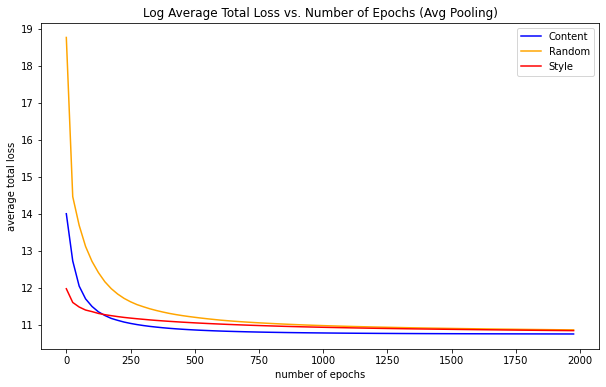

In [51]:
plt.figure(figsize=[10,6])
plt.plot(range(0, 2000, 25), np.log(content_losses_np.mean(axis=0)), color = "blue")
plt.plot(range(0, 2000, 25), np.log(random_losses_np.mean(axis=0)), color = "orange")
plt.plot(range(0, 2000, 25), np.log(style_losses_np.mean(axis=0)), color = "red")
plt.legend(labels = ["Content", "Random", "Style"], loc = "upper right")
plt.xlabel("number of epochs")
plt.ylabel("average total loss")
plt.title("Log Average Total Loss vs. Number of Epochs (Avg Pooling)")
plt.draw()
plt.ioff()
plt.show()

In [26]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "content", 1000, 25, output_dir+'content_avg_1000/')

Iteration: 25, loss: 287420.718750
Iteration: 50, loss: 109534.992188
Iteration: 75, loss: 73757.781250
Iteration: 100, loss: 61850.632812
Iteration: 125, loss: 55850.664062
Iteration: 150, loss: 52117.757812
Iteration: 175, loss: 49624.195312
Iteration: 200, loss: 47836.562500
Iteration: 225, loss: 46396.468750
Iteration: 250, loss: 45286.234375
Iteration: 275, loss: 44418.609375
Iteration: 300, loss: 43742.800781
Iteration: 325, loss: 43133.242188
Iteration: 350, loss: 42621.312500
Iteration: 375, loss: 42179.359375
Iteration: 400, loss: 41817.390625
Iteration: 425, loss: 41503.046875
Iteration: 450, loss: 41222.148438
Iteration: 475, loss: 40966.671875
Iteration: 500, loss: 40728.714844
Iteration: 525, loss: 40511.933594
Iteration: 550, loss: 40313.296875
Iteration: 575, loss: 40140.765625
Iteration: 600, loss: 39994.964844
Iteration: 625, loss: 39856.945312
Iteration: 650, loss: 39729.507812
Iteration: 675, loss: 39617.945312
Iteration: 700, loss: 39502.437500
Iteration: 725, loss:

In [27]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "random", 1000, 25, output_dir+'random_avg_1000/')

Iteration: 25, loss: 1605298.000000
Iteration: 50, loss: 308585.375000
Iteration: 75, loss: 186435.828125
Iteration: 100, loss: 134918.453125
Iteration: 125, loss: 108977.539062
Iteration: 150, loss: 92382.718750
Iteration: 175, loss: 80099.101562
Iteration: 200, loss: 71547.742188
Iteration: 225, loss: 65431.570312
Iteration: 250, loss: 61087.664062
Iteration: 275, loss: 57729.367188
Iteration: 300, loss: 55254.347656
Iteration: 325, loss: 53385.457031
Iteration: 350, loss: 51786.632812
Iteration: 375, loss: 50488.640625
Iteration: 400, loss: 49319.738281
Iteration: 425, loss: 48345.503906
Iteration: 450, loss: 47531.757812
Iteration: 475, loss: 46733.917969
Iteration: 500, loss: 46071.339844
Iteration: 525, loss: 45432.238281
Iteration: 550, loss: 44882.777344
Iteration: 575, loss: 44404.265625
Iteration: 600, loss: 43933.042969
Iteration: 625, loss: 43507.972656
Iteration: 650, loss: 43130.812500
Iteration: 675, loss: 42777.445312
Iteration: 700, loss: 42476.429688
Iteration: 725, l

In [28]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "style", 1000, 25, output_dir+'style_avg_1000/')

Iteration: 25, loss: 96520.382812
Iteration: 50, loss: 74410.859375
Iteration: 75, loss: 66275.546875
Iteration: 100, loss: 61591.773438
Iteration: 125, loss: 58651.726562
Iteration: 150, loss: 56344.597656
Iteration: 175, loss: 54540.023438
Iteration: 200, loss: 53070.164062
Iteration: 225, loss: 51901.343750
Iteration: 250, loss: 50851.824219
Iteration: 275, loss: 49918.851562
Iteration: 300, loss: 49102.035156
Iteration: 325, loss: 48335.472656
Iteration: 350, loss: 47653.390625
Iteration: 375, loss: 47028.441406
Iteration: 400, loss: 46486.664062
Iteration: 425, loss: 45963.085938
Iteration: 450, loss: 45491.394531
Iteration: 475, loss: 45046.312500
Iteration: 500, loss: 44628.023438
Iteration: 525, loss: 44242.386719
Iteration: 550, loss: 43887.632812
Iteration: 575, loss: 43523.445312
Iteration: 600, loss: 43191.878906
Iteration: 625, loss: 42895.304688
Iteration: 650, loss: 42629.984375
Iteration: 675, loss: 42360.199219
Iteration: 700, loss: 42119.359375
Iteration: 725, loss: 4

In [29]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "content", 500, 25, output_dir+'content_avg_500/')

Iteration: 25, loss: 287508.437500
Iteration: 50, loss: 108158.101562
Iteration: 75, loss: 74132.367188
Iteration: 100, loss: 62083.226562
Iteration: 125, loss: 55868.820312
Iteration: 150, loss: 52252.632812
Iteration: 175, loss: 49653.625000
Iteration: 200, loss: 47910.648438
Iteration: 225, loss: 46472.140625
Iteration: 250, loss: 45362.882812
Iteration: 275, loss: 44510.957031
Iteration: 300, loss: 43765.582031
Iteration: 325, loss: 43184.031250
Iteration: 350, loss: 42676.628906
Iteration: 375, loss: 42219.832031
Iteration: 400, loss: 41836.058594
Iteration: 425, loss: 41505.632812
Iteration: 450, loss: 41223.644531
Iteration: 475, loss: 40960.730469
Iteration: 500, loss: 40733.550781
Iteration: 25, loss: 650821.937500
Iteration: 50, loss: 167385.515625
Iteration: 75, loss: 69997.554688
Iteration: 100, loss: 45269.164062
Iteration: 125, loss: 35320.769531
Iteration: 150, loss: 31038.808594
Iteration: 175, loss: 28237.648438
Iteration: 200, loss: 26388.316406
Iteration: 225, loss: 

In [30]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "random", 500, 25, output_dir+'random_avg_500/')

Iteration: 25, loss: 1727825.125000
Iteration: 50, loss: 319189.812500
Iteration: 75, loss: 185153.968750
Iteration: 100, loss: 140562.203125
Iteration: 125, loss: 111091.414062
Iteration: 150, loss: 92322.335938
Iteration: 175, loss: 80028.000000
Iteration: 200, loss: 70713.328125
Iteration: 225, loss: 64488.789062
Iteration: 250, loss: 60177.429688
Iteration: 275, loss: 57077.539062
Iteration: 300, loss: 54906.398438
Iteration: 325, loss: 53103.628906
Iteration: 350, loss: 51663.835938
Iteration: 375, loss: 50434.261719
Iteration: 400, loss: 49376.378906
Iteration: 425, loss: 48424.132812
Iteration: 450, loss: 47599.761719
Iteration: 475, loss: 46912.851562
Iteration: 500, loss: 46285.855469
Iteration: 25, loss: 5024603.500000
Iteration: 50, loss: 1085884.250000
Iteration: 75, loss: 300514.031250
Iteration: 100, loss: 110128.179688
Iteration: 125, loss: 68359.875000
Iteration: 150, loss: 51855.480469
Iteration: 175, loss: 43959.199219
Iteration: 200, loss: 38781.156250
Iteration: 225

In [31]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "style", 500, 25, output_dir+'style_avg_500/')

Iteration: 25, loss: 95415.640625
Iteration: 50, loss: 73840.671875
Iteration: 75, loss: 66170.375000
Iteration: 100, loss: 61993.820312
Iteration: 125, loss: 58930.878906
Iteration: 150, loss: 56598.414062
Iteration: 175, loss: 54687.515625
Iteration: 200, loss: 53240.140625
Iteration: 225, loss: 51993.562500
Iteration: 250, loss: 50905.023438
Iteration: 275, loss: 49972.125000
Iteration: 300, loss: 49143.343750
Iteration: 325, loss: 48375.289062
Iteration: 350, loss: 47726.152344
Iteration: 375, loss: 47098.156250
Iteration: 400, loss: 46554.281250
Iteration: 425, loss: 46025.976562
Iteration: 450, loss: 45518.343750
Iteration: 475, loss: 45083.855469
Iteration: 500, loss: 44658.312500
Iteration: 25, loss: 59236.136719
Iteration: 50, loss: 46061.492188
Iteration: 75, loss: 40275.054688
Iteration: 100, loss: 36916.195312
Iteration: 125, loss: 34465.023438
Iteration: 150, loss: 32571.359375
Iteration: 175, loss: 30932.566406
Iteration: 200, loss: 29549.421875
Iteration: 225, loss: 2838

In [32]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "content", 200, 25, output_dir+'content_avg_200/')

Iteration: 25, loss: 301201.937500
Iteration: 50, loss: 115656.546875
Iteration: 75, loss: 74828.117188
Iteration: 100, loss: 62137.597656
Iteration: 125, loss: 55887.371094
Iteration: 150, loss: 52183.687500
Iteration: 175, loss: 49706.992188
Iteration: 200, loss: 47919.421875
Iteration: 25, loss: 644999.812500
Iteration: 50, loss: 187304.406250
Iteration: 75, loss: 72648.265625
Iteration: 100, loss: 45187.433594
Iteration: 125, loss: 35425.578125
Iteration: 150, loss: 30884.177734
Iteration: 175, loss: 28180.919922
Iteration: 200, loss: 26299.113281
Iteration: 25, loss: 1520102.750000
Iteration: 50, loss: 472436.625000
Iteration: 75, loss: 254700.671875
Iteration: 100, loss: 183625.546875
Iteration: 125, loss: 149063.406250
Iteration: 150, loss: 129886.812500
Iteration: 175, loss: 118479.843750
Iteration: 200, loss: 110894.546875
Iteration: 25, loss: 3419820.000000
Iteration: 50, loss: 812831.750000
Iteration: 75, loss: 323534.406250
Iteration: 100, loss: 217471.718750
Iteration: 125

In [33]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "random", 200, 25, output_dir+'random_avg_200/')

Iteration: 25, loss: 1227793.000000
Iteration: 50, loss: 309846.281250
Iteration: 75, loss: 184797.093750
Iteration: 100, loss: 138633.781250
Iteration: 125, loss: 110505.742188
Iteration: 150, loss: 92106.070312
Iteration: 175, loss: 79604.593750
Iteration: 200, loss: 70428.375000
Iteration: 25, loss: 1973927.000000
Iteration: 50, loss: 355916.750000
Iteration: 75, loss: 117871.289062
Iteration: 100, loss: 67081.007812
Iteration: 125, loss: 51838.445312
Iteration: 150, loss: 43749.175781
Iteration: 175, loss: 38793.335938
Iteration: 200, loss: 35105.738281
Iteration: 25, loss: 8067645.000000
Iteration: 50, loss: 2401661.500000
Iteration: 75, loss: 1129857.750000
Iteration: 100, loss: 650713.750000
Iteration: 125, loss: 439746.312500
Iteration: 150, loss: 336653.843750
Iteration: 175, loss: 278652.906250
Iteration: 200, loss: 240302.359375
Iteration: 25, loss: 11340284.000000
Iteration: 50, loss: 3625001.000000
Iteration: 75, loss: 1925423.625000
Iteration: 100, loss: 1173195.875000
It

In [34]:
for i in range(len(style_images)):
    run_transfer(style_images[i], content_images[i], "style", 200, 25, output_dir+'style_avg_200/')

Iteration: 25, loss: 96676.007812
Iteration: 50, loss: 73740.617188
Iteration: 75, loss: 65713.015625
Iteration: 100, loss: 61632.195312
Iteration: 125, loss: 58495.992188
Iteration: 150, loss: 56368.664062
Iteration: 175, loss: 54574.476562
Iteration: 200, loss: 53202.589844
Iteration: 25, loss: 59255.566406
Iteration: 50, loss: 46147.460938
Iteration: 75, loss: 40241.042969
Iteration: 100, loss: 36933.093750
Iteration: 125, loss: 34421.335938
Iteration: 150, loss: 32495.177734
Iteration: 175, loss: 30857.234375
Iteration: 200, loss: 29480.449219
Iteration: 25, loss: 243979.156250
Iteration: 50, loss: 185001.859375
Iteration: 75, loss: 165537.546875
Iteration: 100, loss: 154063.796875
Iteration: 125, loss: 146851.890625
Iteration: 150, loss: 141234.218750
Iteration: 175, loss: 137018.984375
Iteration: 200, loss: 133427.609375
Iteration: 25, loss: 318558.187500
Iteration: 50, loss: 166989.359375
Iteration: 75, loss: 139686.750000
Iteration: 100, loss: 123191.359375
Iteration: 125, loss

In [35]:
# test block, will eventually remove it
#temp1 = Image.open(image_dir+style_name)
#img_resize = transforms.Resize((temp.height, temp.width))
#temp_resized = img_resize(temp1)
#plt.imshow(temp_resized)
#temp_resized.save(output_dir + "c" + content_name[8:10] + "_s" + style_name[6:8] + ".png")